In [1]:
%reload_ext autoreload
%autoreload 2
import os, datetime
from itertools import product, repeat
import pickle
import tqdm
import matplotlib.pyplot as plt
import jax
import jax.random as jr
import jax.numpy as jnp
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import koopcore
from koopcore.auxilliary.data_classes import trajectory

2023-11-17 11:37:05.295751: W external/xla/xla/service/gpu/nvptx_compiler.cc:702] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
try:
    DEVICES = jax.devices("gpu")[1:]
except:
    DEVICES = jax.devices("cpu")
finally:
    jax.config.update("jax_enable_x64", True)

PRNGKEY = jr.PRNGKey(44)

# Configure Experiments

In [3]:
STEPS = 98
DT = 1 / STEPS
N_TRAIN = 40
N_TEST = 9
D = 200
id_observable = [100* 25 + 80]
params_base_kernel = {"name": "square-exponential", "p_kernel":{"scale":7e1}}
SMALLEST_LENGTHSCALE = 5*1e-1
LARGEST_LENGTHSCALE = 1e4
N_LENGTHSCALES = 20
N_SPLITS = 5


PATH_TO_DATA = "./results/LBM_cylinder_vortex_street"
save_path = os.path.join(".","results", "cylinder_vortex_street")


## Function Definitions

In [4]:
def generate_eigenvalues_dt(D, PRNGKey):
    PRNGKey, subkey =  jax.random.split(PRNGKey)
    e = jax.random.uniform(subkey, [D])
    N1 = D//2
    e = jax.random.permutation (PRNGKey, jnp.stack([
        -e[:N1], 
        (e[N1:]-0.5)*1j * 2
        ]).reshape(-1),
        independent=True)
    return koopcore.auxilliary.eigenvalues.convert_ct_to_dt(jnp.squeeze(e), 1)
def get_target(data):
    return data.select_d(id_observable)

In [5]:

def train_test_split(PRNGKEY, data_load, data_t, N_TRAIN, N_TEST):
    _N_total = data_load.shape[0]
    i_all = jax.random.choice(PRNGKEY, _N_total, [N_TEST+  N_TRAIN], replace=False)
    i_train = i_all[:N_TRAIN]
    i_test = i_all[N_TRAIN:N_TEST+N_TRAIN]

    data_train = {"x": trajectory(data_load[i_train], data_t), "y":get_target(trajectory(data_load[i_train], data_t))}
    data_test = {"x": trajectory(data_load[i_test], data_t), "y":get_target(trajectory(data_load[i_test], data_t))}
    return data_train, data_test
def preprocess_data(data_train, data_test):
    preprocessor = {"x": MinMaxScaler((-1, 1)), "y": MinMaxScaler((-1, 1))}
    preprocessor["x"].fit(data_train["x"][:, 0, :])
    preprocessor["y"].fit(data_train["y"][:, 0, :])
    for d in [data_train, data_test]:
        for i in ["x", "y"]:
            d[i].set_X(preprocessor[i].transform(d[i].X.reshape(-1, d[i].d)).reshape(-1, d[i].H, d[i].d) )
    return preprocessor, data_train, data_test
def postprocess_data(data, preprocessor):
    for i in ["x", "y"]:
        data[i].X  = preprocessor[i].transform(data[i].X.reshape(-1, data[i].d)).reshape(-1, data[i].H, data[i].d)
    return  data

In [6]:
def fit_KKR_model(data_train, data_test, eigenvalues, lengthscale, result, run, device):
    KKR_model = koopcore.model.kkr_estimator.KoopmanKernelDTRegressor(
        eigenvalues=eigenvalues,
        preprocessor=MinMaxScaler((-1., 1)),
        kernel_name=params_base_kernel["name"],
        kernel_params={"scale": lengthscale},
        timestep=DT,
        device=device,
        regularizer_invariant=1e-8,
        regularizer_isometric=1e-8
    )
    KKR_model.fit(data_train["x"], data_train["y"])
    prediction_train = KKR_model.predict(data_train["x"][:, 0, :], STEPS)
    prediction_test = KKR_model.predict(data_test["x"][:, 0, :], STEPS)
    residual_train = data_train["y"]-prediction_train
    residual_test = data_test["y"]-prediction_test
    os.makedirs(os.path.join(save_path, "models"), exist_ok=True)
    KKR_model.save(os.path.join(save_path, "models", f"KKR_model_{run}.pkl"))

    L2_errors_train = koopcore.auxilliary.p_norm((residual_train).X, [0, 1, 2], 2)
    L2_errors_test = koopcore.auxilliary.p_norm((residual_test).X, [0, 1, 2], 2)
    result[str(run)] = {"lengthscale": lengthscale, "L2_errors_train": L2_errors_train, "L2_errors_test": L2_errors_test,
                        "data_test": data_test, "data_train": data_train, "prediction_test": prediction_test, "prediction_train": prediction_train}
    return result


def experiment(rng, data, data_times, lengthscale, result, run, device):
    rng, subkey = jr.split(rng)
    data_train, data_test = train_test_split(
        subkey, data, data_times, N_TRAIN, N_TEST)
    rng, subkey = jr.split(rng)
    eigenvalues = generate_eigenvalues_dt(D, subkey)
    preprocessor = preprocess_data(data_train, data_test)
    result = fit_KKR_model(data_train, data_test,
                           eigenvalues, lengthscale, result, run, device)
    return result, preprocessor

## Load data

In [7]:
d_target = len(id_observable)
data_load = jnp.load(f"{PATH_TO_DATA}/velocity_magnitude.npy")
dt = 1 / data_load.shape[1]
data_t =  jnp.arange(data_load.shape[1]) *dt
N_total = data_load.shape[0]
assert N_total >= N_TEST + N_TRAIN

## Depict eigenvalue sampling

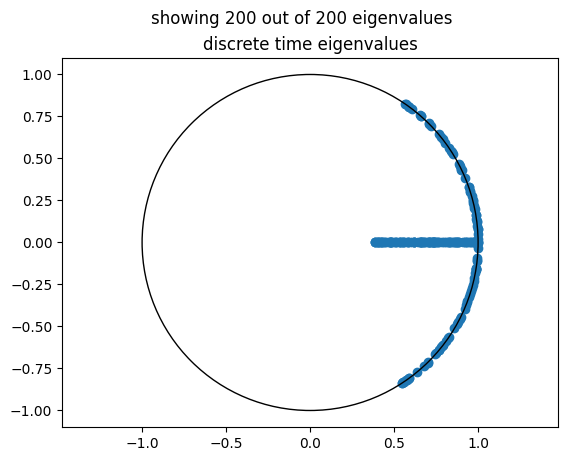

In [8]:
PRNGKEY, subkey = jr.split(PRNGKEY)
eigenvalues = generate_eigenvalues_dt(D, subkey)
koopcore.auxilliary.plot_eigevalues(eigenvalues);

## Setup tasks

In [9]:
variation_lengthscales = jnp.logspace(jnp.log10(SMALLEST_LENGTHSCALE), jnp.log10(LARGEST_LENGTHSCALE), N_LENGTHSCALES).tolist()
PRNGKEY, subkey = jr.split(PRNGKEY)
variation_rng = rng_runs = jr.split(subkey, N_SPLITS)
tasks =list(product(variation_rng, [data_load], [data_t], variation_lengthscales))

## Run experiments

In [10]:
logger = tqdm.tqdm_notebook(total = len(tasks))
log = lambda x: logger.update(x)
workers = koopcore.auxilliary.multithreading.tmap(experiment, DEVICES, log=log)
results = workers(tasks)

## Postprocess data

In [11]:
results_arr = jnp.array([(float(results[k]["lengthscale"]), float(results[k]["L2_errors_train"]), float(results[k]["L2_errors_test"])) for k in results.keys()])
results_arr = results_arr[results_arr[:, 0].argsort()]

In [12]:
results_arr_means = jnp.stack([results_arr[ls == results_arr[:, 0]].mean(axis=0) for ls in variation_lengthscales])
results_arr_max = jnp.stack([results_arr[ls == results_arr[:, 0]].max(axis=0) for ls in variation_lengthscales])
results_arr_min = jnp.stack([results_arr[ls == results_arr[:, 0]].min(axis=0) for ls in variation_lengthscales])

In [13]:
with open(os.path.join(save_path, "simulation_results.pkl"), "wb") as f:
    pickle.dump(results, f)

## Plot results

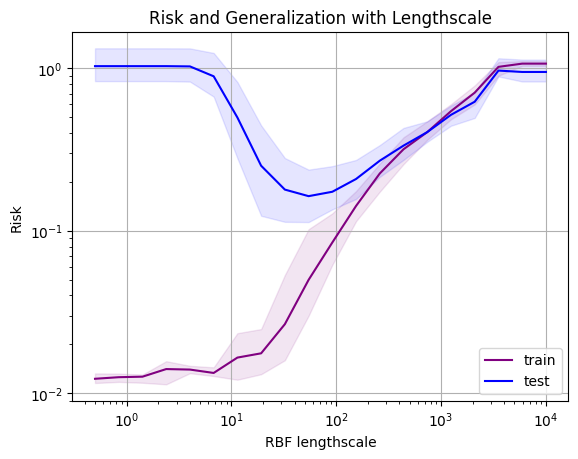

In [14]:
plt.plot(results_arr_means[:, 0], results_arr_means[:, 1],
         "purple", label="train")
plt.plot(results_arr_means[:, 0], results_arr_means[:, 2],
         "blue", label="test")
plt.fill_between(results_arr_min[:, 0], results_arr_min[:, 1],
                 results_arr_max[:, 1], color="purple", alpha=0.1)
plt.fill_between(results_arr_min[:, 0], results_arr_min[:, 2],
                 results_arr_max[:, 2], color="blue", alpha=0.1)
plt.xlabel("RBF lengthscale");plt.ylabel("Risk")
plt.title("Risk and Generalization with Lengthscale")
plt.legend();plt.grid();plt.loglog();

In [15]:
best_test_i = jnp.where(results_arr_min[:, 2]== results_arr_min[:,2].min())[0][0]
result_best_run, result_best_test= [(k,v) for k,v in zip(results.keys(), results.values()) if v["lengthscale"] == results_arr_min[best_test_i, 0]][0]

In [ ]:
PRNGKey, subkey = jr.split(PRNGKEY, 2)
i_plot = jr.choice(subkey, N_TRAIN, [min(7, N_TRAIN)], replace=0)
f, _ = koopcore.auxilliary.plot_data( result_best_test["data_train"]["y"], i_plot=i_plot, prepend_tag="data train", plt_params={"alpha":0.3,});
koopcore.auxilliary.plot_data( result_best_test["prediction_train"], i_plot=i_plot, prepend_tag="prediction train", fig=f,plt_params={"linestyle":"dotted",});
PRNGKey, subkey = jr.split(PRNGKey, 2)
i_plot = jr.choice(subkey, N_TEST, [min(7, N_TEST)],  replace=0)
f, _ = koopcore.auxilliary.plot_data( result_best_test["data_test"]["y"], i_plot=i_plot, prepend_tag="data test", plt_params={"alpha":0.3,});
koopcore.auxilliary.plot_data( result_best_test["prediction_test"], i_plot=i_plot, prepend_tag="prediction test", fig=f, plt_params={"linestyle":"dotted"});
print("mean train loss: {}\nmean test loss:\t {}".format(
    koopcore.auxilliary.p_norm((result_best_test["data_train"]["y"] - result_best_test["prediction_train"]).X, a=[0, 1, 2], p=2),
    koopcore.auxilliary.p_norm((result_best_test["data_test"]["y"]  - result_best_test["prediction_test"]).X,  a=[0, 1, 2], p=2)))

In [17]:
best_test_i = jnp.where(results_arr_min[:, 2]== results_arr_min[:,2].min())[0][0]
results_best_lengthscale_kv= [(k,v) for k,v in zip(results.keys(), results.values()) if v["lengthscale"] == results_arr_min[best_test_i, 0]]


In [18]:
cum_error_train = jnp.stack([jax.device_put(jnp.cumsum((v["data_train"]["y"].X - v["prediction_train"].X).__abs__(), axis=1), jax.devices("cpu")[0]) for k,v in results_best_lengthscale_kv])
cum_error_test = jnp.stack([jax.device_put(jnp.cumsum((v["data_test"]["y"].X - v["prediction_test"].X).__abs__(), axis=1), jax.devices("cpu")[0]) for k,v in results_best_lengthscale_kv])

Text(0.5, 1.0, 'Accumulated Error')

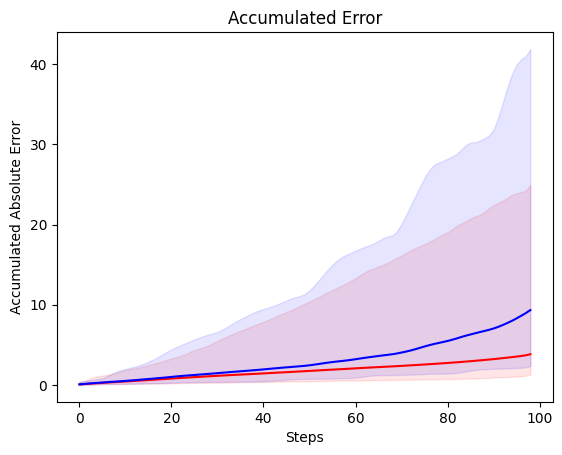

In [19]:
plt.plot(cum_error_train.mean([0,1,3]), color="red")
plt.fill_between(jnp.arange(99), cum_error_train.min([0,1,3]), cum_error_train.max([0,1,3]), color="red", alpha=0.1, label="train")
plt.plot(cum_error_test.mean([0,1,3]), color="blue")
plt.fill_between(jnp.arange(99), cum_error_test.min([0,1,3]), cum_error_test.max([0,1,3]), color="blue", alpha=0.1, label="test")
plt.xlabel("Steps")
plt.ylabel("Accumulated Absolute Error")
plt.title("Accumulated Error")